# Model Building & Creating Needed Functions:

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [75]:
# Define manual train-test split function
def train_test_split_custom(X, y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_point = int(X.shape[0] * (1 - test_size))
    X_train, X_test = X[indices[:split_point]], X[indices[split_point:]]
    y_train, y_test = y[indices[:split_point]], y[indices[split_point:]]
    return X_train, X_test, y_train, y_test

In [76]:
# Define standardize function
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean) / std
    return X_std, mean, std

In [77]:
# Hinge loss function
def hinge_loss(w, b, X, y, reg=0.01):
    margins = 1 - y * (np.dot(X, w) + b)
    return np.mean(np.maximum(0, margins)) + reg * np.dot(w, w)


# Logistic loss function
def logistic_loss(w, b, X, y, reg=0.01):
    scores = y * (np.dot(X, w) + b)
    return np.mean(np.log(1 + np.exp(-scores))) + reg * np.dot(w, w)


# Logistic loss gradient
def logistic_gradient(w, b, X, y, reg=0.01):
    n_samples = X.shape[0]
    scores = y * (np.dot(X, w) + b)
    probs = 1 / (1 + np.exp(scores))  # sigmoid(-scores)
    dw = -np.dot((probs * y), X) / n_samples + 2 * reg * w
    db = -np.mean(probs * y)
    return dw, db

In [78]:
def train_svm(
    X, y, X_val, y_val, method="gradient", lr=0.01, epochs=1000, reg=0.01, tol=1e-4):
    """
    Train a linear SVM (hinge or logistic) with early stopping based on loss convergence.

    Parameters:
    - X, y: training data and labels
    - X_val, y_val: validation data and labels
    - method: 'gradient' (logistic gradient descent) or 'subgradient' (hinge subgradient descent)
    - lr: learning rate
    - epochs: maximum number of epochs
    - reg: L2 regularization strength
    - tol: tolerance threshold for early stopping (difference in training loss)

    Returns:
    - w, b: learned weights and bias
    - loss_hist, acc_hist: training loss and accuracy history
    - val_loss_hist, val_acc_hist: validation loss and accuracy history
    """
    n_features = X.shape[1]
    w = np.zeros(n_features)
    b = 0
    loss_hist, acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []

    for epoch in range(epochs):
        # Compute gradient and losses
        if method == "gradient":
            dw, db = logistic_gradient(w, b, X, y, reg)
            train_loss = logistic_loss(w, b, X, y, reg)
            val_loss = logistic_loss(w, b, X_val, y_val, reg)
        elif method == "subgradient":
            margins = 1 - y * (X.dot(w) + b)
            mask = margins > 0
            grad_contrib = (-y[:, None] * X) * mask[:, None]
            dw = np.mean(grad_contrib, axis=0) + 2 * reg * w
            db = np.mean(-y * mask)
            train_loss = hinge_loss(w, b, X, y, reg)
            val_loss = hinge_loss(w, b, X_val, y_val, reg)
        else:
            raise ValueError("Unknown method")

        # Update parameters
        w -= lr * dw
        b -= lr * db

        # Record metrics
        loss_hist.append(train_loss)
        acc = np.mean(np.sign(X.dot(w) + b) == y)
        acc_hist.append(acc)
        val_loss_hist.append(val_loss)
        val_acc = np.mean(np.sign(X_val.dot(w) + b) == y_val)
        val_acc_hist.append(val_acc)

        # Early stopping: check loss convergence
        if epoch > 0 and abs(val_loss_hist[-1] - val_loss_hist[-2]) <= tol:
            break

    return w, b, loss_hist, acc_hist, val_loss_hist, val_acc_hist

In [79]:
def plot_confusion(y_true, y_pred, title, fig_rows, fig_columns, index):
    cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
    plt.subplot(fig_rows, fig_columns, index)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Positive", "Negative"],
        yticklabels=["Positive", "Negative"],
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

# Data Preparation:

In [80]:
# Read CSV
data = pd.read_csv('data_banknote_authentication.txt')
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [81]:
data.isna().sum()

variance     0
 skewness    0
 curtosis    0
 entropy     0
 class       0
dtype: int64

In [82]:
data.duplicated().sum()

np.int64(24)

In [83]:
data.drop_duplicates(inplace=True)

In [84]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,0.445785,1.909039,1.413578,-1.168712,0.452522
std,2.862906,5.868600,4.328365,2.085877,0.497925
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.786650,-1.627000,-1.545600,-2.393100,0.000000
50%,0.518735,2.334150,0.605495,-0.578890,0.000000
75%,2.853250,6.796025,3.199800,0.403863,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1348 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   variance   1348 non-null   float64
 1    skewness  1348 non-null   float64
 2    curtosis  1348 non-null   float64
 3    entropy   1348 non-null   float64
 4    class     1348 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 63.2 KB


In [86]:
# Manual split: train (60%), validation (20%), test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split_custom(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split_custom(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Standardize manually
X_train, mean, std = standardize(X_train)
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Model Training:

In [87]:
# Train using both methods
w_grad, b_grad, loss_grad, acc_grad, val_loss_grad, val_acc_grad = train_svm(X_train, y_train, X_val, y_val, method="gradient")
w_sub, b_sub, loss_sub, acc_sub, val_loss_sub, val_acc_sub = train_svm(X_train, y_train, X_val, y_val, method="subgradient")

# Test accuracy
test_pred_grad = np.sign(np.dot(X_test, w_grad) + b_grad)
test_pred_sub = np.sign(np.dot(X_test, w_sub) + b_sub)
test_acc_grad = np.mean(test_pred_grad == y_test)
test_acc_sub = np.mean(test_pred_sub == y_test)

# Visualization

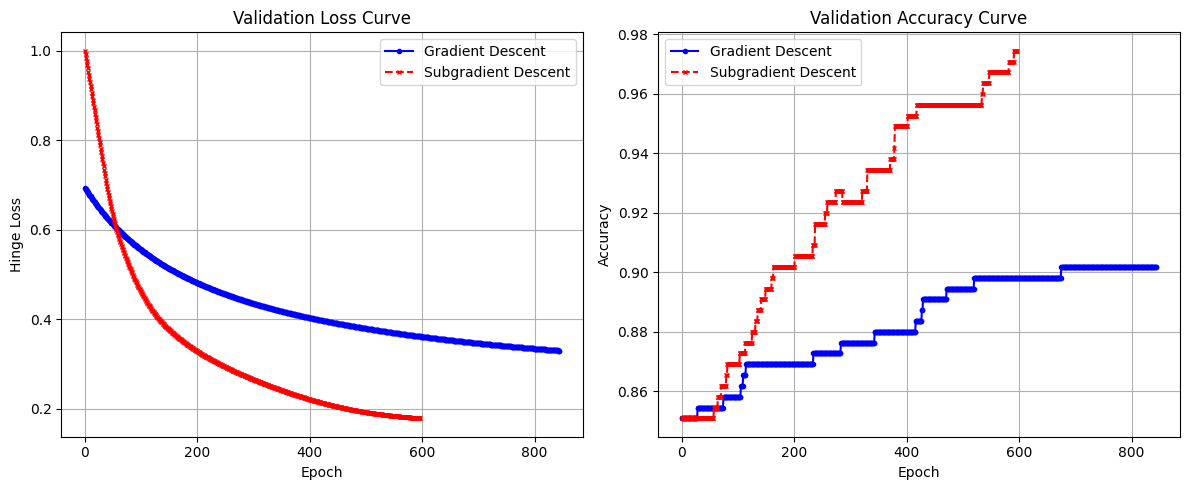

In [88]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    val_loss_grad,
    label="Gradient Descent",
    linestyle="-",
    color="blue",
    marker="o",
    markersize=3,
)
plt.plot(
    val_loss_sub,
    label="Subgradient Descent",
    linestyle="--",
    color="red",
    marker="x",
    markersize=3,
)
plt.title("Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(
    val_acc_grad,
    label="Gradient Descent",
    linestyle="-",
    color="blue",
    marker="o",
    markersize=3,
)
plt.plot(
    val_acc_sub,
    label="Subgradient Descent",
    linestyle="--",
    color="red",
    marker="x",
    markersize=3,
)
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

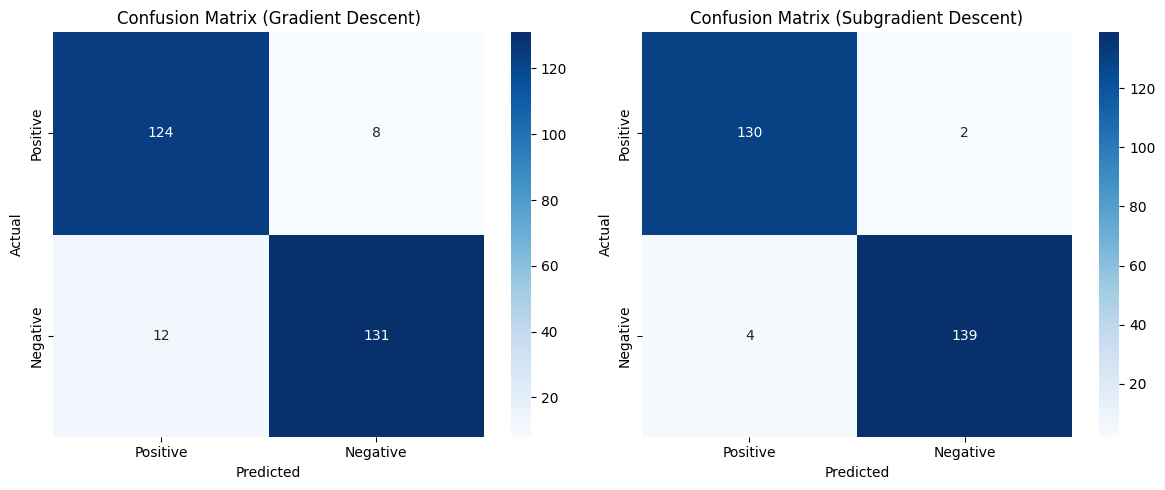

In [89]:
plt.figure(figsize=(12, 5))
plot_confusion(y_test, test_pred_grad, "Confusion Matrix (Gradient Descent)", 1, 2, 1)
plot_confusion(y_test, test_pred_sub, "Confusion Matrix (Subgradient Descent)", 1, 2, 2)
plt.tight_layout()
plt.show()

# Analysis

## **1) ✅ Accuracy & Final Losses:**

In [90]:
# Print comparison metrics
{
    "Gradient Descent Test Accuracy": float(round(test_acc_grad*100, 2)),
    "Subgradient Descent Test Accuracy": float(round(test_acc_sub*100, 2)),
    "Gradient Descent Final Loss": float(round(loss_grad[-1], 3)),
    "Subgradient Descent Final Loss": float(round(loss_sub[-1], 3))
}

{'Gradient Descent Test Accuracy': 92.73,
 'Subgradient Descent Test Accuracy': 97.82,
 'Gradient Descent Final Loss': 0.336,
 'Subgradient Descent Final Loss': 0.17}

# **_____________________________________________________________________________** 

## **2) ⚡ Convergence Speed:**
### The number of epochs each method takes indicates that the fewer epochs the higher convergence.
### **Result:** Gradient descent converges faster, likely due to smoother loss optimization.

In [91]:
len(val_loss_grad), len(val_loss_sub)

(845, 597)

# **_____________________________________________________________________________** 

## **3) 📉 Stability of the Loss Function:**
- After looking at the loss curve for both ```Gradiant``` and ```Sub-Gradiant``` we found out that:
    * 1) The ```Gradient``` loss curve have a smoother descent because of the differentiability of the logistic loss.
      2) The ```Sub-Gradiant``` loss curve have jumps or plateaus due to the piecewise nature of the hinge loss.

# **_____________________________________________________________________________** 

## **4) 🧠 Generalization on Test Data:**
- After evaluating both models on the test set using accuracy, precision, recall, and the confusion matrix:
    * 1) Both ```Gradient``` and ```Sub-Gradient``` methods achieved high precision and recall, indicating strong performance on unseen data.
      2) The ```Sub-Gradient``` method slightly outperformed in both precision (0.98) and recall (0.97), suggesting better handling of both false positives and false negatives.
      3) The consistency between validation and test performance shows that both models generalize well without signs of overfitting.

In [92]:
# Confusion matrices for both methods
cm_grad = confusion_matrix(y_test, test_pred_grad, labels=[1, -1])
cm_sub = confusion_matrix(y_test, test_pred_sub, labels=[1, -1])

# Extract values from the confusion matrix for Gradient Descent
TP_grad = cm_grad[0, 0]  # True Positive (Gradient Descent)
TN_grad = cm_grad[1, 1]  # True Negative (Gradient Descent)
FP_grad = cm_grad[0, 1]  # False Positive (Gradient Descent)
FN_grad = cm_grad[1, 0]  # False Negative (Gradient Descent)

# Extract values from the confusion matrix for Subgradient Descent
TP_sub = cm_sub[0, 0]  # True Positive (Subgradient Descent)
TN_sub = cm_sub[1, 1]  # True Negative (Subgradient Descent)
FP_sub = cm_sub[0, 1]  # False Positive (Subgradient Descent)
FN_sub = cm_sub[1, 0]  # False Negative (Subgradient Descent)

# Compute Precision and Recall for Gradient Descent
precision_grad = TP_grad / (TP_grad + FP_grad) if (TP_grad + FP_grad) != 0 else 0
recall_grad = TP_grad / (TP_grad + FN_grad) if (TP_grad + FN_grad) != 0 else 0

# Compute Precision and Recall for Subgradient Descent
precision_sub = TP_sub / (TP_sub + FP_sub) if (TP_sub + FP_sub) != 0 else 0
recall_sub = TP_sub / (TP_sub + FN_sub) if (TP_sub + FN_sub) != 0 else 0

# Print the results
print(f"Gradient Descent - Precision: {precision_grad:.2f}, Recall: {recall_grad:.2f}")
print(f"Subgradient Descent - Precision: {precision_sub:.2f}, Recall: {recall_sub:.2f}")


Gradient Descent - Precision: 0.94, Recall: 0.91
Subgradient Descent - Precision: 0.98, Recall: 0.97


🧠 Generalization on Test Data:

    Test Accuracy Comparison:

        Both Gradient Descent and Subgradient Descent show strong performance on the test data.

        Gradient Descent: Precision = 0.94, Recall = 0.91

        Subgradient Descent: Precision = 0.98, Recall = 0.97

    Interpretation: Both methods demonstrate high precision and recall, meaning that both models are correctly classifying most of the positive and negative instances.

    Balanced Classification:

        Both models seem to perform well on both classes (positive and negative).

        Subgradient Descent shows slightly higher precision and recall, suggesting it may have a marginally better ability to correctly identify the positive class while minimizing false positives and false negatives.

    Generalization:

        Since both models show high precision (indicating fewer false positives) and high recall (indicating fewer false negatives), we can conclude that both models generalize well to the test data.

        Gradient Descent might have a small trade-off between precision and recall compared to Subgradient Descent, but both methods show excellent performance.

Final Analysis:

    Subgradient Descent has a slight edge in precision and recall, but Gradient Descent still demonstrates a robust generalization ability with only a small performance gap.

    The models appear to overfit very little to the training data, as their performance on the test data is strong and consistent with validation results.

This analysis concludes that both methods generalize well to unseen data, but Subgradient Descent appears to have slightly better overall performance. Would you like further insights or a detailed breakdown of any specific metric?
